In [192]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# Небольшой класс для препроцессинга

In [193]:
class SimpleDataPreprocessing(object):
    def __init__(
            self,
            df,
            list_of_drop_columns=None,
            metro_dist_fill_meth='most_common',
    ):
        self.df = df
        self.date_to_numerical()
        self.metro_dist_fill_meth = metro_dist_fill_meth
        self.list_of_drop_columns = list_of_drop_columns
        self.replace_nan_metro_dist(self.metro_dist_fill_meth)
        self.replace_nan()

        if self.drop_columns is not None:
            self.drop_columns(self.list_of_drop_columns)

    def date_to_numerical(self):
        """
        Замена категориальный данных численными.
        Столбец 'date'
        Заменяем данные на количество месяцев, начиная с первой даты
        """
        # self.df['date'] = pd.to_datetime(self.df['date']).sub(pd.Timestamp(self.df.date[0])).dt.days // 30
        self.df['date'] = pd.to_datetime(self.df['date']).dt.month + \
                          12 * (pd.to_datetime(self.df['date']).dt.year - min(pd.to_datetime(self.df['date']).dt.year))

    def replace_nan_metro_dist(self, fill_type):
        if fill_type == 'mean':
            self.df.loc[pd.isnull(self.df['metro_dist']), 'metro_dist'] = round(self.df['metro_dist'].mean())
            return
        if fill_type == 'most_common':
            self.df.loc[pd.isnull(self.df['metro_dist']), 'metro_dist'] = \
                train_data['metro_dist'].value_counts().index.tolist()[0]
            return

    def replace_nan(self):
        """
        Заменяем пропуски NaN
        """
        # for column in self.df:
        #     self.df.loc[pd.isnull(self.df[column]), column] = \
        #         train_data[column].value_counts().index.tolist()[0]
        for column in self.df:
            self.df.loc[pd.isnull(self.df[column]), column] = -1

    def drop_nan_lines(self, columns):
        for column in columns:
            self.df = self.df.drop(self.df[pd.isnull(self.df[column])].index)

    def drop_columns(self, columns):
        """
        Удаляем колонки
        """
        self.df.drop(columns=columns, inplace=True)

    def return_preprocessed_df(self):
        return self.df

In [194]:
train_data = pd.read_csv('./Train.csv', delimiter=',')    # Train data
test_data = pd.read_csv('./Test.csv', delimiter=',')    # Test data

# Построим гистограммы по столбцам

<AxesSubplot:>

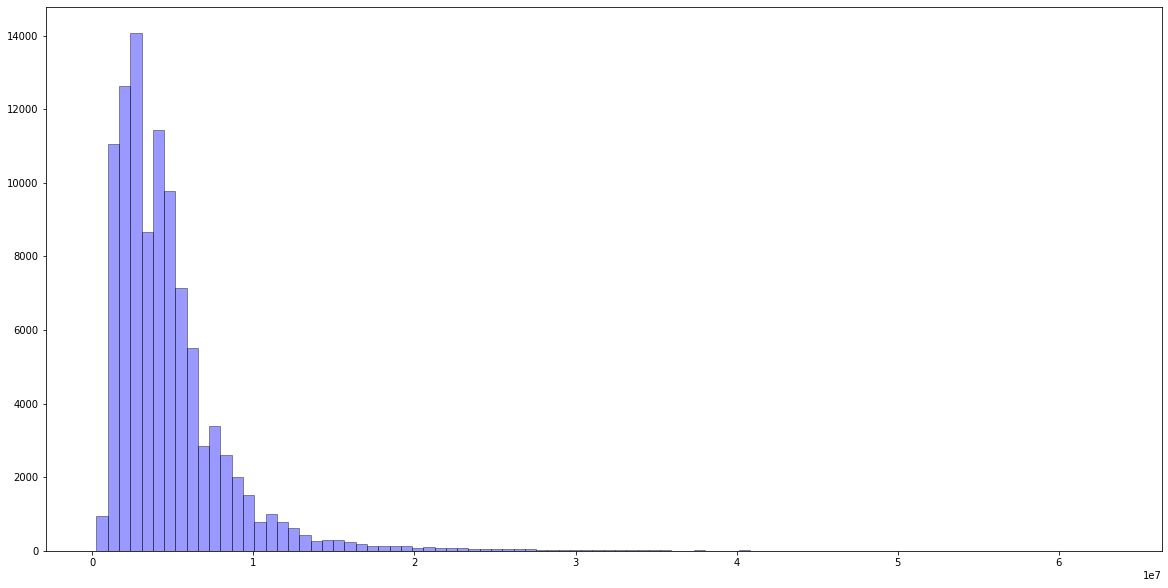

In [195]:
plt.figure(figsize=(20, 10))
sns.distplot(preprocessed_train_data.price.values, hist=True, kde=False, 
             bins=int(180/2), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='metro_dist'>

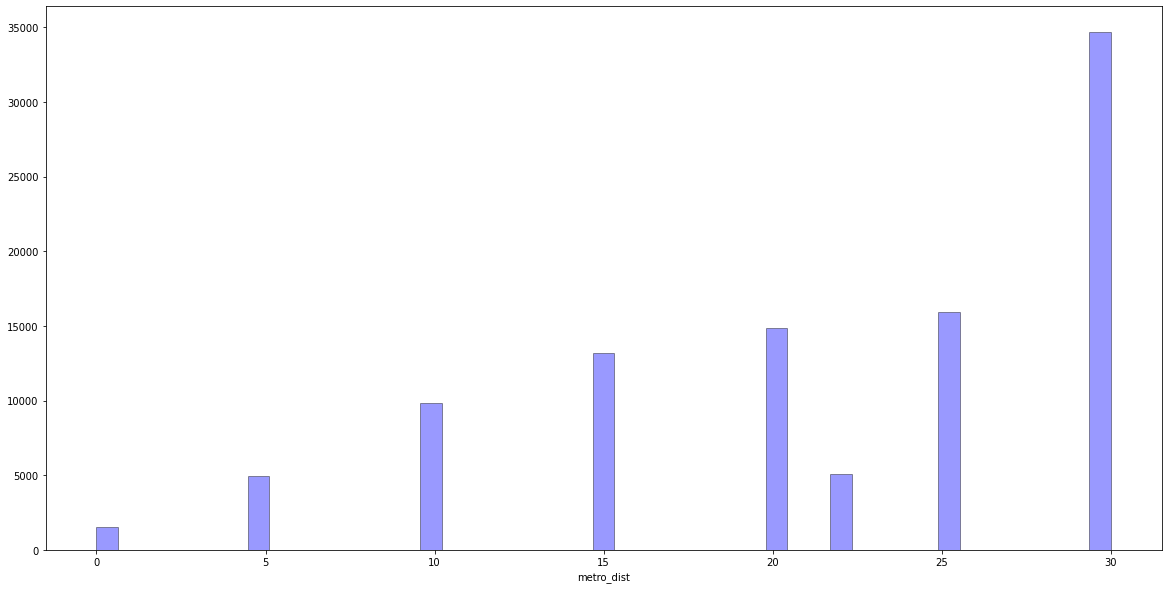

In [196]:
plt.figure(figsize=(20, 10))
sns.distplot(1 / preprocessed_train_data.metro_dist, hist=True, kde=False,
             color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='area'>

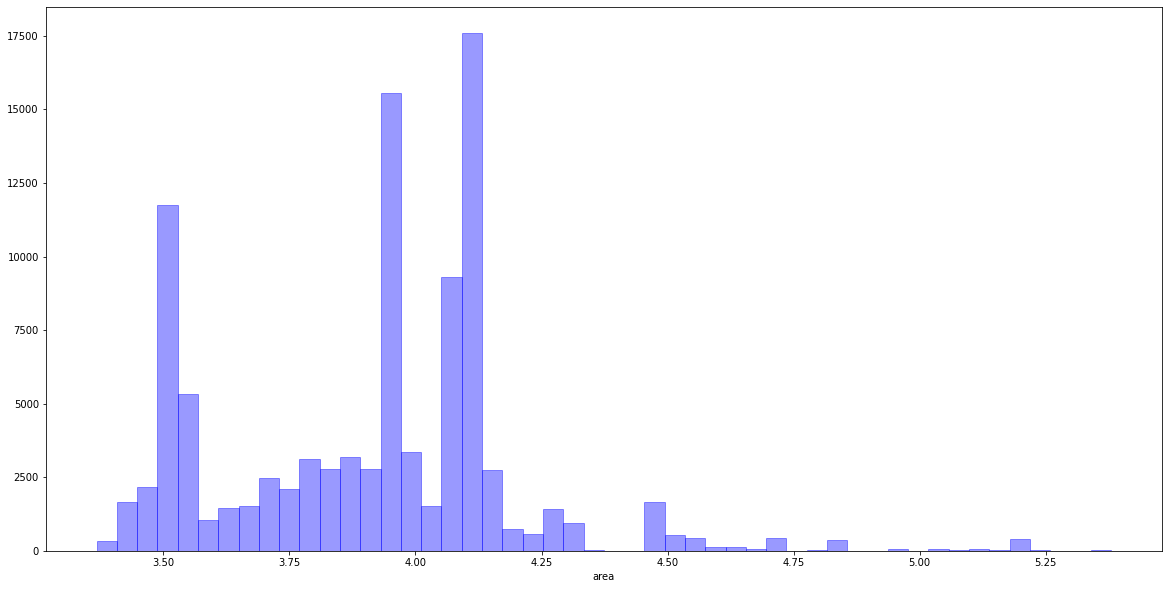

In [197]:
plt.figure(figsize=(20, 10))
sns.distplot(preprocessed_train_data.area, hist=True, kde=False,
             color = 'blue',
             hist_kws={'edgecolor':'b'})

<AxesSubplot:xlabel='date'>

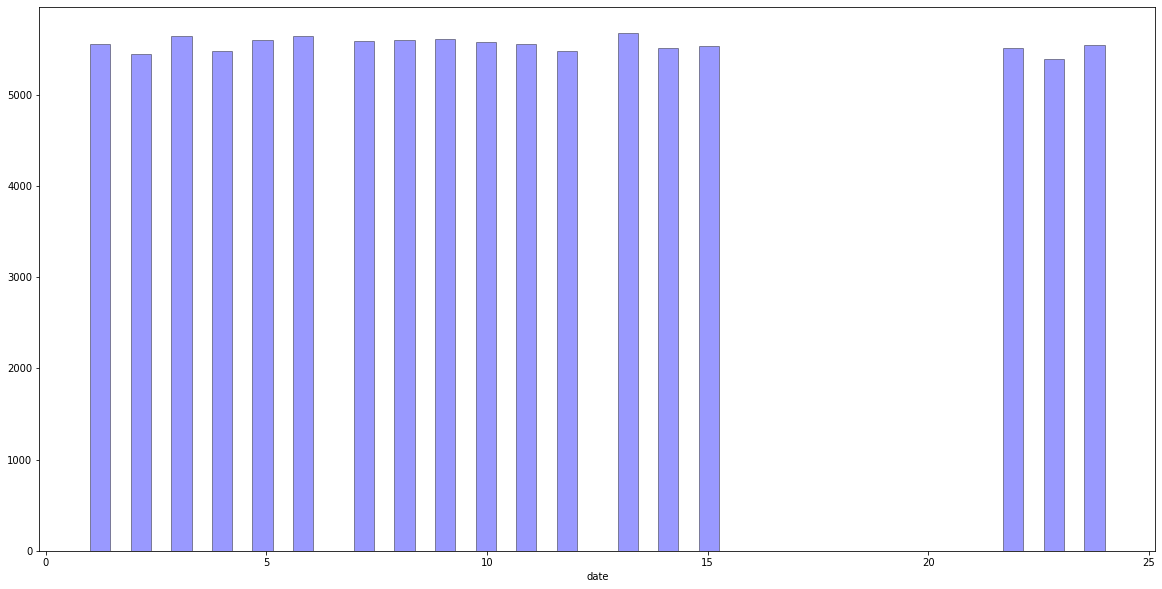

In [198]:
plt.figure(figsize=(20, 10))
sns.distplot(preprocessed_train_data.date, hist=True, kde=False,
             color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='kw2'>

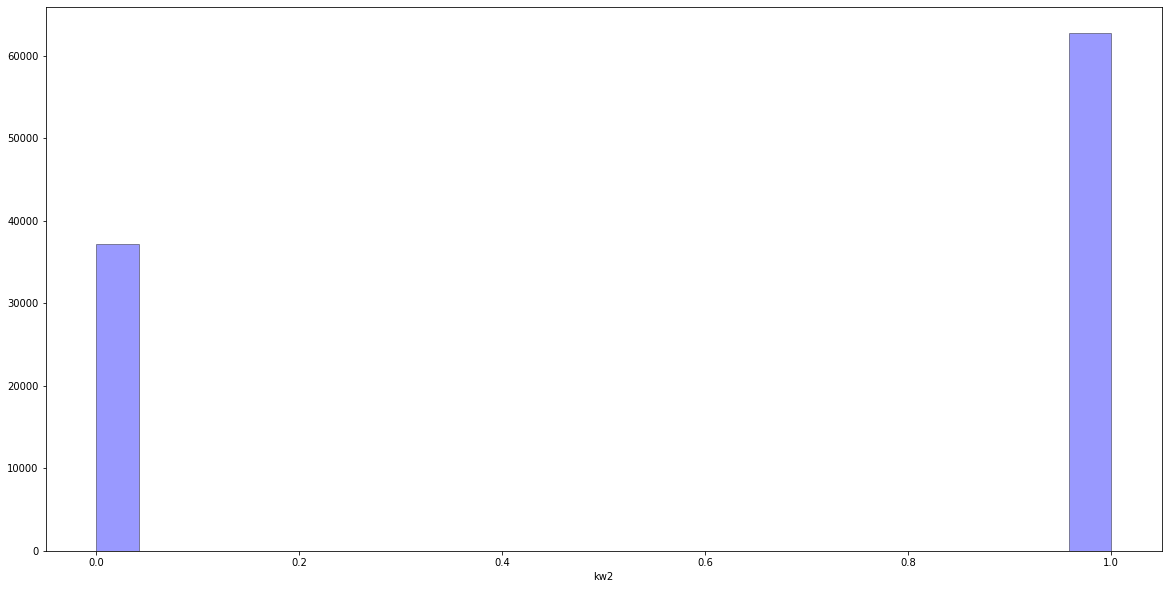

In [199]:
plt.figure(figsize=(20, 10))
sns.distplot(preprocessed_train_data['kw2'], hist=True, kde=False,
             color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='kw1'>

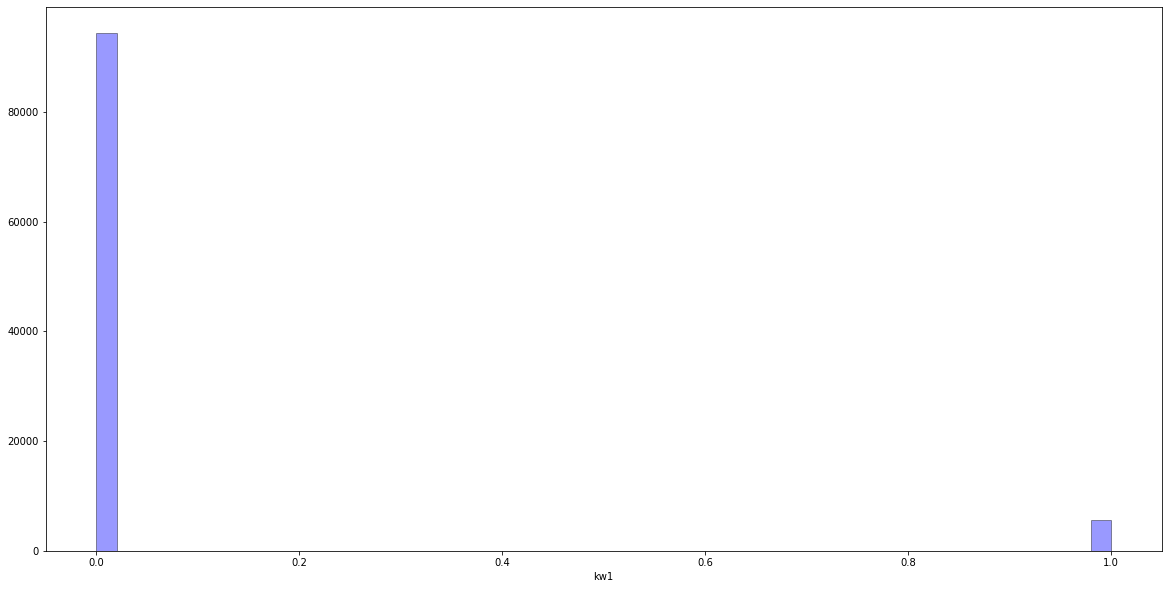

In [200]:
plt.figure(figsize=(20, 10))
sns.distplot(preprocessed_train_data['kw1'], hist=True, kde=False,
             color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='kw3'>

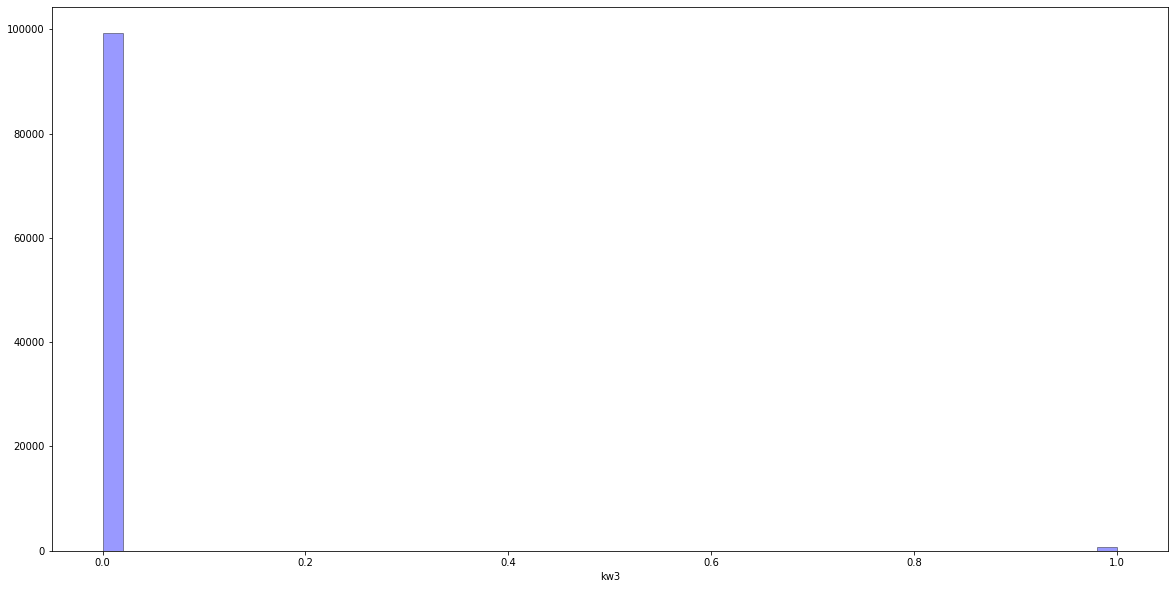

In [201]:
plt.figure(figsize=(20, 10))
sns.distplot(preprocessed_train_data['kw3'], hist=True, kde=False,
             color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='kw4'>

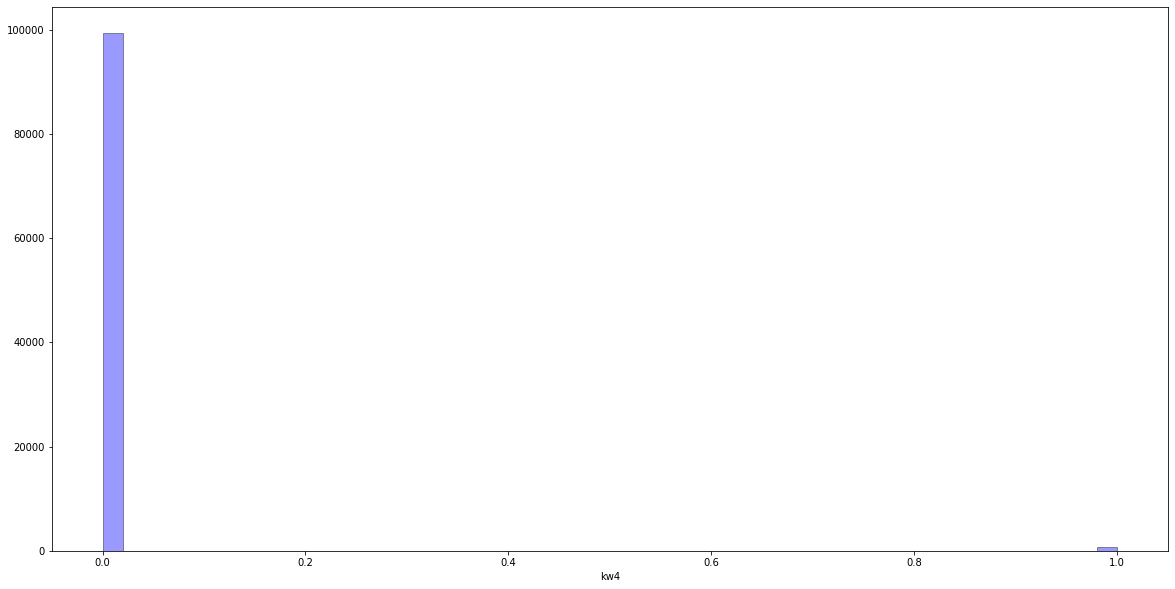

In [202]:
plt.figure(figsize=(20, 10))
sns.distplot(preprocessed_train_data['kw4'], hist=True, kde=False,
             color = 'blue',
             hist_kws={'edgecolor':'black'})

<font size=3>Можно заметить, что признаки kw1, kw3 - kw13 в основном забиты нулями, и скорее всего их нужно дропнуть.

# Построим зависимости некоторых признаков от цены

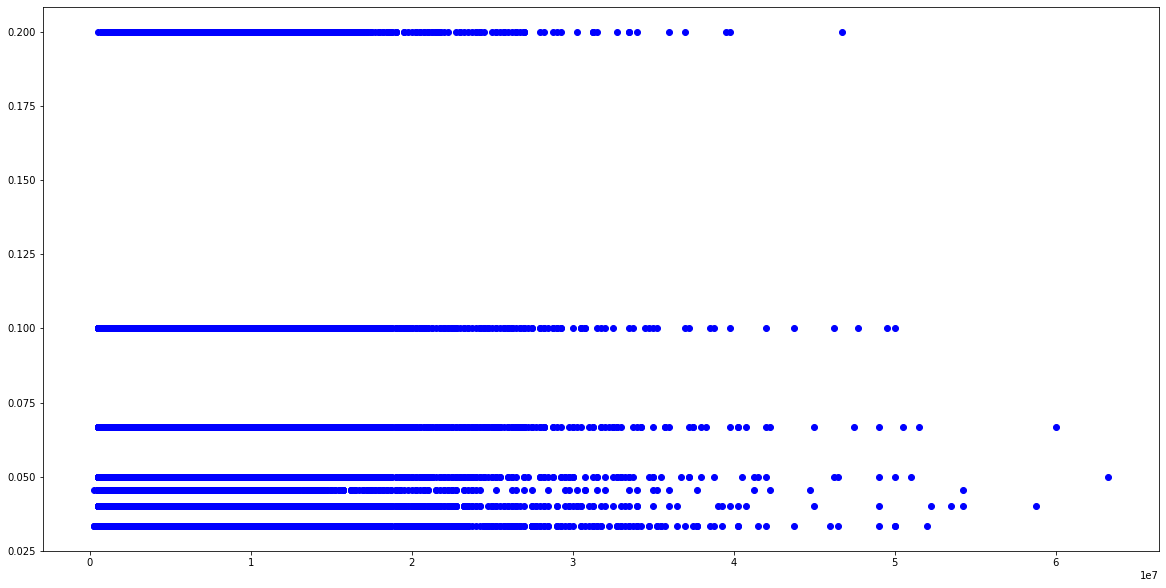

In [203]:
plt.figure(figsize=(20, 10))
plt.scatter(preprocessed_train_data.price, preprocessed_train_data.metro_dist, color = 'blue')

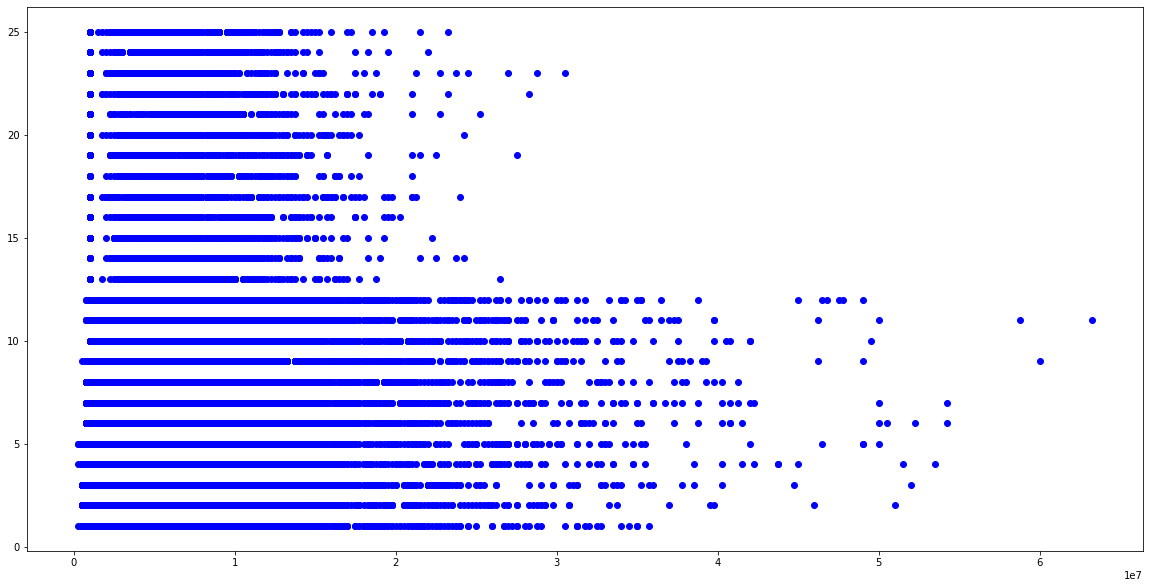

In [204]:
plt.figure(figsize=(20, 10))
plt.scatter(preprocessed_train_data.price, preprocessed_train_data.floor, color = 'blue')

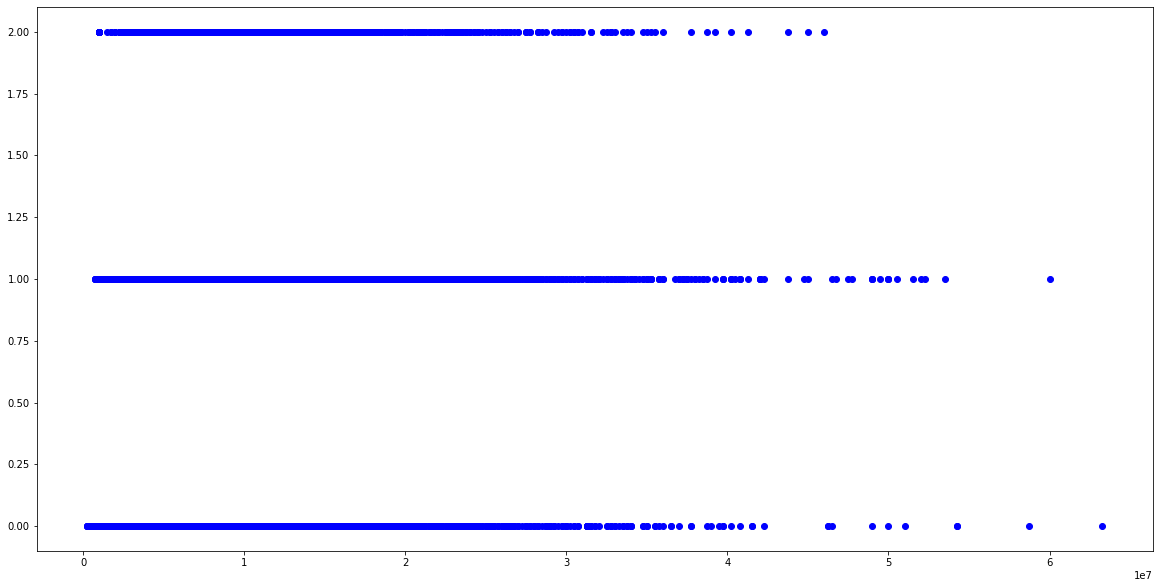

In [205]:
plt.figure(figsize=(20, 10))
plt.scatter(preprocessed_train_data.price, preprocessed_train_data.build_tech, color = 'blue')

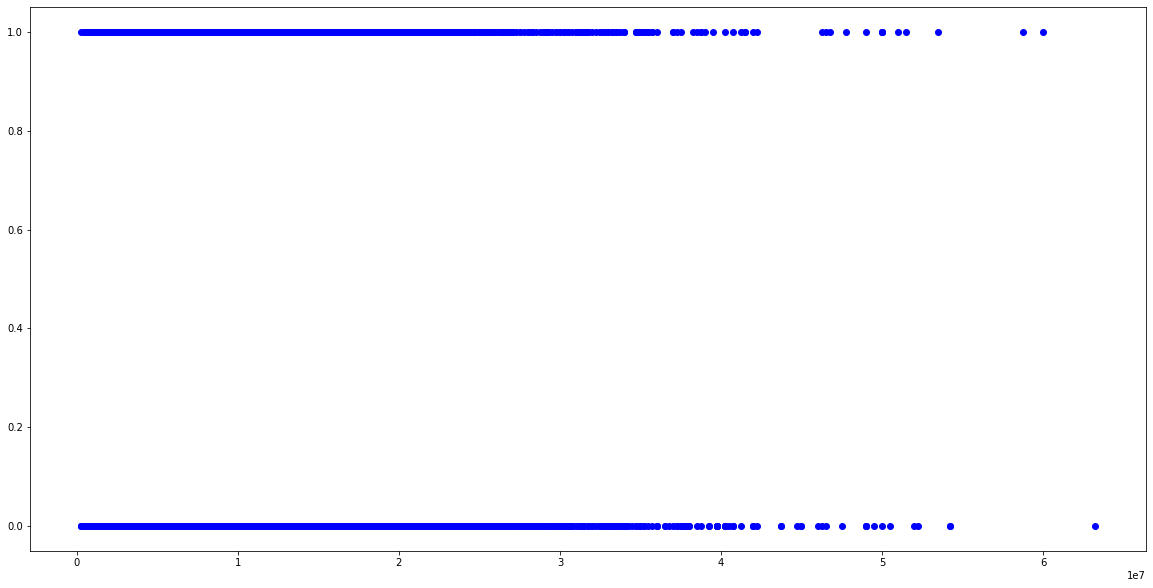

In [206]:
plt.figure(figsize=(20, 10))
plt.scatter(preprocessed_train_data.price, preprocessed_train_data.g_lift, color = 'blue')

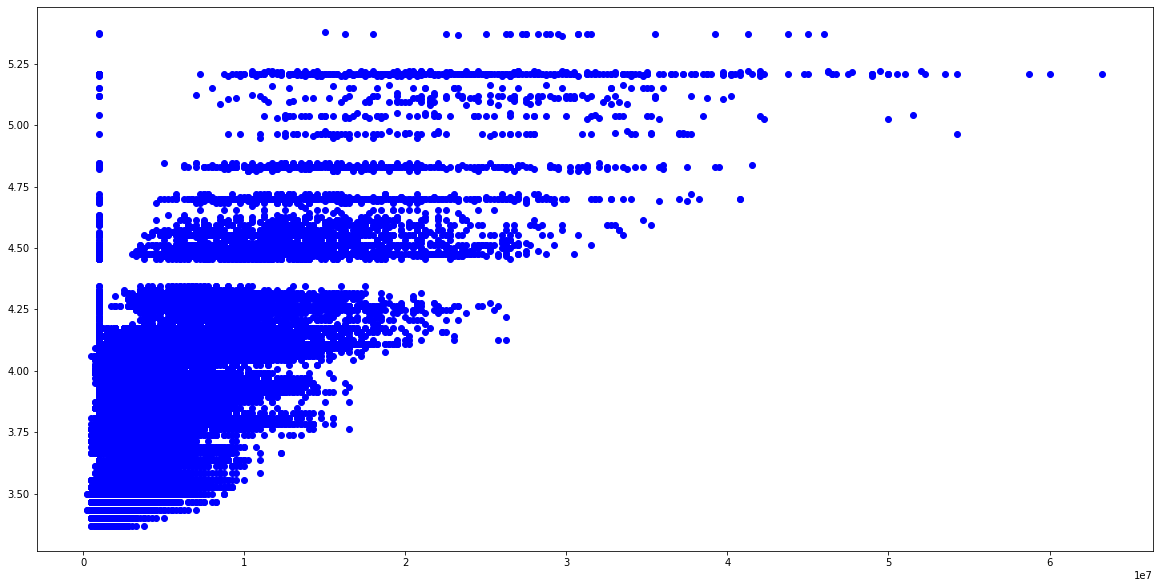

In [207]:
plt.figure(figsize=(20, 10))
plt.scatter(preprocessed_train_data.price, preprocessed_train_data.area, color = 'blue')

<font size=3>Нашли выбросы: нереалистичное соотношение $\frac{цена}{площадь}$. Необходимо подчистить датасет. Как видно из рисунка, они имеют значение цены = константе. Найдем это значение, затем подчистим. 

In [208]:
df = preprocessed_train_data[preprocessed_train_data.area > np.log(150)]
sorted_df = df.sort_index().sort_values('price', kind='mergesort')
print(sorted_df.loc[:, ['area', 'price']].head(20))


           area      price
201    5.204007  1000000.0
7438   5.209486  1000000.0
18735  5.209486  1000000.0
20575  5.153292  1000000.0
30586  5.209486  1000000.0
31145  5.198497  1000000.0
39679  5.204007  1000000.0
42671  5.153292  1000000.0
43216  5.209486  1000000.0
44119  5.117994  1000000.0
46065  5.209486  1000000.0
46437  5.375278  1000000.0
54919  5.370638  1000000.0
55879  5.117994  1000000.0
56840  5.209486  1000000.0
61242  5.209486  1000000.0
69038  5.209486  1000000.0
70898  5.209486  1000000.0
71174  5.209486  1000000.0
71264  5.209486  1000000.0


<font size = 3>Предварительный анализ данных можно сделать утверждение, что:
    
    -почти все признаки являются категориальными (кроме площади)
    -некоторые призныки спокойно можно удалить
    -были обнаружены шумовые значения.
<font>

In [209]:
# Удаляемые индексы
deleting_indexes = [
    0,  # id
    # 1,  # date
    # 2,  # street_id
    # 3,  # build_tech
    # 4,  # floor
    # 5,  # area
    # 6,  # rooms
    # 7,  # balcon
    # 8,  # metro_dist
    # 9,  # g_lift
    # 10,  # n_photos
    11,  # kw1
    # 12,  # kw2
    13,  # kw3
    14,  # kw4
    15,  # kw5
    16,  # kw6
    17,  # kw7
    18,  # kw8
    19,  # kw9
    20,  # kw10
    21,  # kw11
    22,  # kw12
    23,  # kw13
]


deleting_columns = list()
for i, column in enumerate(train_data):
    if i in deleting_indexes:
        deleting_columns.append(column)

In [210]:
# Создаем экземпляры класса, предобрабатываем данные
TestData = SimpleDataPreprocessing(test_data, list_of_drop_columns=deleting_columns,)
TrainData = SimpleDataPreprocessing(train_data, list_of_drop_columns=deleting_columns,)

preprocessed_test_data = TestData.return_preprocessed_df()
preprocessed_train_data = TrainData.return_preprocessed_df()

# Удаляем шум
preprocessed_train_data = \
    preprocessed_train_data.drop(preprocessed_train_data[(preprocessed_train_data.price == 1e6)].index)

y_train = preprocessed_train_data.price.values.astype(int)
preprocessed_train_data.drop(columns=['price'], inplace=True)

dict_of_columns = dict()
for i, column in enumerate(preprocessed_train_data):
    dict_of_columns[column] = i
print(dict_of_columns)


# Можно увидеть из графика, что точки ложатся не совсем линейно (площадь от цены)
# пусть будет корень, мб логарифм был бы и лучше
preprocessed_train_data['area'] = np.sqrt(preprocessed_train_data['area'])
preprocessed_test_data['area'] = np.sqrt(preprocessed_test_data['area'])


# Переводим все колонки предобработанного датафрейма в int, кроме площади (для catboost'а)
for column in preprocessed_train_data:
    if column not in ['area']:
        preprocessed_train_data[column] = preprocessed_train_data[column].values.astype(int)

for column in preprocessed_test_data:
    if column not in ['area']:
        preprocessed_test_data[column] = preprocessed_test_data[column].values.astype(int)



{'date': 0, 'street_id': 1, 'build_tech': 2, 'floor': 3, 'area': 4, 'rooms': 5, 'balcon': 6, 'metro_dist': 7, 'g_lift': 8, 'n_photos': 9, 'kw2': 10}


In [211]:
# Проводим сплит для предварительной оценки датасета
X_train_train, X_train_test, y_train_train, y_train_test = \
    train_test_split(
        preprocessed_train_data, y_train,
        test_size=0.25,
    )

# CatBoostRegressor

In [212]:
# Объявляем, какие фичи будут категориальными
cat_features = [
    # dict_of_columns['date'],
    dict_of_columns['street_id'],
    dict_of_columns['build_tech'],
    dict_of_columns['floor'],
    # dict_of_columns['area'],
    dict_of_columns['rooms'],
    dict_of_columns['balcon'],
    dict_of_columns['metro_dist'],
    dict_of_columns['g_lift'],
    dict_of_columns['n_photos'],
    # dict_of_columns['kw1'],
    dict_of_columns['kw2'],
    # dict_of_columns['kw3'],
    # dict_of_columns['kw4'],
    # dict_of_columns['kw5'],
    # dict_of_columns['kw6'],
    # dict_of_columns['kw7'],
    # dict_of_columns['kw8'],
    # dict_of_columns['kw9'],
    # dict_of_columns['kw10'],
    # dict_of_columns['kw11'],
    # dict_of_columns['kw12'],
    # dict_of_columns['kw13']
]

# Объявляем регрессор
cb_regressor = CatBoostRegressor(
    loss_function='RMSE',
    learning_rate=0.25,
    iterations=500,
    # num_leaves=20,
    bootstrap_type='MVS',
    max_depth=12,
    od_type='Iter'
)

In [213]:
print(f'cat_features:\n{cat_features}', X_train.shape)
cb_regressor.fit(X_train_train, y_train_train, cat_features=cat_features)
cb_predict = cb_regressor.predict(X_train_test)
print(mean_absolute_error(y_train_test, cb_predict))

cat_features:
[1, 2, 3, 5, 6, 7, 8, 9, 10] (95998, 11)
0:	learn: 3026064.4641373	total: 371ms	remaining: 3m 5s
1:	learn: 2506422.0143335	total: 702ms	remaining: 2m 54s
2:	learn: 2121392.6837084	total: 983ms	remaining: 2m 42s
3:	learn: 1844339.2702687	total: 1.28s	remaining: 2m 38s
4:	learn: 1652384.4907799	total: 1.54s	remaining: 2m 32s
5:	learn: 1519676.0364330	total: 1.84s	remaining: 2m 31s
6:	learn: 1431084.3358360	total: 2.15s	remaining: 2m 31s
7:	learn: 1362963.4799235	total: 2.45s	remaining: 2m 30s
8:	learn: 1310005.9685245	total: 2.77s	remaining: 2m 31s
9:	learn: 1268801.1062921	total: 3.12s	remaining: 2m 32s
10:	learn: 1238507.1865657	total: 3.41s	remaining: 2m 31s
11:	learn: 1216000.6933770	total: 3.77s	remaining: 2m 33s
12:	learn: 1182506.7927507	total: 4.12s	remaining: 2m 34s
13:	learn: 1154165.5746514	total: 4.42s	remaining: 2m 33s
14:	learn: 1132310.5581514	total: 4.72s	remaining: 2m 32s
15:	learn: 1112889.0293751	total: 5.01s	remaining: 2m 31s
16:	learn: 1097358.4103628	t

143:	learn: 563793.6378497	total: 49s	remaining: 2m 1s
144:	learn: 562209.4244074	total: 49.3s	remaining: 2m
145:	learn: 561403.3125900	total: 49.7s	remaining: 2m
146:	learn: 559535.8913724	total: 50s	remaining: 2m
147:	learn: 557648.3832728	total: 50.3s	remaining: 1m 59s
148:	learn: 554974.9397205	total: 50.7s	remaining: 1m 59s
149:	learn: 553620.9605900	total: 51s	remaining: 1m 58s
150:	learn: 552016.6832084	total: 51.2s	remaining: 1m 58s
151:	learn: 550930.0646584	total: 51.6s	remaining: 1m 58s
152:	learn: 548464.6734105	total: 51.9s	remaining: 1m 57s
153:	learn: 546721.7407147	total: 52.2s	remaining: 1m 57s
154:	learn: 544596.7700198	total: 52.5s	remaining: 1m 56s
155:	learn: 543333.8976708	total: 52.8s	remaining: 1m 56s
156:	learn: 541287.8645607	total: 53.2s	remaining: 1m 56s
157:	learn: 540447.6195797	total: 53.5s	remaining: 1m 55s
158:	learn: 538829.3362004	total: 53.8s	remaining: 1m 55s
159:	learn: 536667.1677793	total: 54.2s	remaining: 1m 55s
160:	learn: 534907.9088287	total:

284:	learn: 386654.4062372	total: 1m 41s	remaining: 1m 16s
285:	learn: 385708.3922515	total: 1m 41s	remaining: 1m 15s
286:	learn: 385235.0516245	total: 1m 41s	remaining: 1m 15s
287:	learn: 384289.1936161	total: 1m 42s	remaining: 1m 15s
288:	learn: 383510.1617161	total: 1m 42s	remaining: 1m 14s
289:	learn: 382900.8148722	total: 1m 43s	remaining: 1m 14s
290:	learn: 382474.2216709	total: 1m 43s	remaining: 1m 14s
291:	learn: 381502.7797480	total: 1m 44s	remaining: 1m 14s
292:	learn: 380396.6069190	total: 1m 44s	remaining: 1m 13s
293:	learn: 379330.0921949	total: 1m 44s	remaining: 1m 13s
294:	learn: 378077.5665657	total: 1m 45s	remaining: 1m 13s
295:	learn: 377402.7259399	total: 1m 45s	remaining: 1m 12s
296:	learn: 376483.7824779	total: 1m 46s	remaining: 1m 12s
297:	learn: 375916.1490675	total: 1m 46s	remaining: 1m 12s
298:	learn: 374563.9669039	total: 1m 46s	remaining: 1m 11s
299:	learn: 374123.3834780	total: 1m 47s	remaining: 1m 11s
300:	learn: 373554.9980857	total: 1m 47s	remaining: 1m 1

426:	learn: 288124.6051738	total: 2m 33s	remaining: 26.3s
427:	learn: 287503.0400094	total: 2m 34s	remaining: 25.9s
428:	learn: 287094.4660275	total: 2m 34s	remaining: 25.6s
429:	learn: 286107.7910908	total: 2m 34s	remaining: 25.2s
430:	learn: 285291.5062592	total: 2m 35s	remaining: 24.8s
431:	learn: 284930.9227317	total: 2m 35s	remaining: 24.5s
432:	learn: 284351.1385554	total: 2m 35s	remaining: 24.1s
433:	learn: 283490.6026984	total: 2m 36s	remaining: 23.8s
434:	learn: 282536.5041240	total: 2m 36s	remaining: 23.4s
435:	learn: 282077.7842067	total: 2m 36s	remaining: 23s
436:	learn: 281496.4436563	total: 2m 37s	remaining: 22.7s
437:	learn: 280846.0751728	total: 2m 37s	remaining: 22.3s
438:	learn: 280351.2159344	total: 2m 37s	remaining: 21.9s
439:	learn: 279663.6447612	total: 2m 38s	remaining: 21.6s
440:	learn: 278977.1071589	total: 2m 38s	remaining: 21.2s
441:	learn: 277977.3367079	total: 2m 39s	remaining: 20.9s
442:	learn: 277367.9302407	total: 2m 39s	remaining: 20.5s
443:	learn: 2763

# Обучаем регрессор на всем трейне,  фитим на тестовой выборке, затем записываем данные в .csv

In [ ]:
# cb_regressor.fit(preprocessed_train_data, y_train, cat_features=cat_features)
# cb_predict = cb_regressor.predict(preprocessed_test_data)
# df = pd.DataFrame({'id': np.arange(1e5, 1e5 + test_data.shape[0], dtype=int), 'price': cb_predict})
# df.to_csv('submission_15.csv', index=False)